# Plotting data on a cubed sphere grid with cartopy

When using cartopy, standard calls to `pcolor` or `pcolormesh` do not always work for all faces on a cubed sphere grid (I believe [this open GitHub issue](https://github.com/SciTools/cartopy/issues/1151) is related).  The workaround illustrated here was largely derived/simplified from the last two cells of this [extensive exploratory notebook by Daniel Rothenberg](https://nbviewer.jupyter.org/gist/darothen/8bf53b448790f21f616552b45ee3b22b/cubed_sphere_mesh.ipynb#Test-using-real-data).

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr

from matplotlib.collections import PolyCollection
from matplotlib.colors import Normalize
%matplotlib inline

In [2]:
def construct_corners(ds):
    coords = ds[['grid_lon', 'grid_lat']]
    
    ll = coords.isel(
        grid_x=slice(None, -1),
        grid_y=slice(None, -1), 
        drop=True
    ).to_array().rename('ll')
    
    ul = coords.isel(
        grid_x=slice(1, None),
        grid_y=slice(None, -1), 
        drop=True
    ).to_array().rename('ul')

    lr = coords.isel(
        grid_x=slice(None, -1),
        grid_y=slice(1, None), 
        drop=True
    ).to_array().rename('lr')
    
    ur = coords.isel(
        grid_x=slice(1, None),
        grid_y=slice(1, None), 
        drop=True
    ).to_array().rename('ur')

    corners = xr.merge(
        [ll, ul, ur, lr, ll.rename('ll_cyclic')]
    ).to_array(dim='corner')
    corners = corners.stack(polygon=('grid_x', 'grid_y', 'tile'))
    return corners.transpose('polygon', 'corner', 'variable')

In [3]:
GRID_SPEC = 'grid_spec.tile*.nc'
DATA = 'atmos_4xdaily.tile*.nc'
VAR = 'Q925'

grid = xr.open_mfdataset(
    GRID_SPEC,
    concat_dim='tile', 
    combine='nested'
).load()
corners = construct_corners(grid)

data = xr.open_mfdataset(
    DATA, 
    concat_dim='tile',
    combine='nested'
).isel(time=0)[VAR].load().stack(polygon=('grid_xt', 'grid_yt', 'tile'))

### Without grid lines

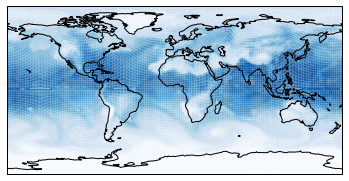

In [4]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})

coll = PolyCollection(
    corners, lw=0., edgecolors='k',
    transform=ccrs.Geodetic()
)
coll.set_array(data)
coll.set_cmap('Blues')
coll.set_norm(Normalize(0.0, 0.02))
coll.set_clim(0.0, 0.02)
coll.set_alpha(1.)

c = ax.add_collection(coll, autolim=False)

ax.coastlines()
ax.set_global()

### With grid lines

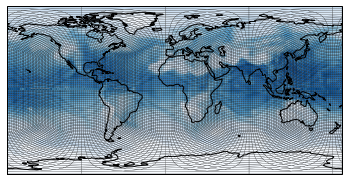

In [5]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})

coll = PolyCollection(
    corners, lw=0.2, edgecolors='k',
    transform=ccrs.Geodetic()
)
coll.set_array(data)
coll.set_cmap('Blues')
coll.set_norm(Normalize(0.0, 0.02))
coll.set_clim(0.0, 0.02)
coll.set_alpha(1.)

c = ax.add_collection(coll, autolim=False)

ax.coastlines()
ax.set_global()

### Orthographic projection

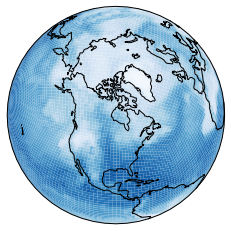

In [6]:
fig, ax = plt.subplots(
    1, 
    1, 
    subplot_kw={
        'projection': ccrs.Orthographic(central_longitude=270, central_latitude=60)
    }
)

coll = PolyCollection(
    corners, lw=0., edgecolors='k',
    transform=ccrs.Geodetic()
)
coll.set_array(data)
coll.set_cmap('Blues')
coll.set_norm(Normalize(0.0, 0.02))
coll.set_clim(0.0, 0.02)
coll.set_alpha(1.)

c = ax.add_collection(coll, autolim=False)

ax.coastlines()
ax.set_global()